In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.style.use('seaborn')
sns.set(font_scale=2)
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.set_random_seed(777)
import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_train = pd.read_csv('./data/train_b_summer.csv')

In [3]:
df_train.head()

,date&time,AC,Furnace,temp,hum,dayofweeks
0,2014-06-01 0:00,0.000042,0.009793,49.59,0.86,0
1,2014-06-01 1:00,0.000046,0.009809,47.53,0.88,0
2,2014-06-01 2:00,0.000069,0.009747,46.13,0.89,0
3,2014-06-01 3:00,0.000057,0.009808,45.47,0.90,0
4,2014-06-01 4:00,0.000056,0.009798,44.45,0.90,0


In [4]:
df_train.drop(['date&time'], axis=1, inplace=True)

In [5]:
df_train.head()

,AC,Furnace,temp,hum,dayofweeks
0,0.000042,0.009793,49.59,0.86,0
1,0.000046,0.009809,47.53,0.88,0
2,0.000069,0.009747,46.13,0.89,0
3,0.000057,0.009808,45.47,0.90,0
4,0.000056,0.009798,44.45,0.90,0


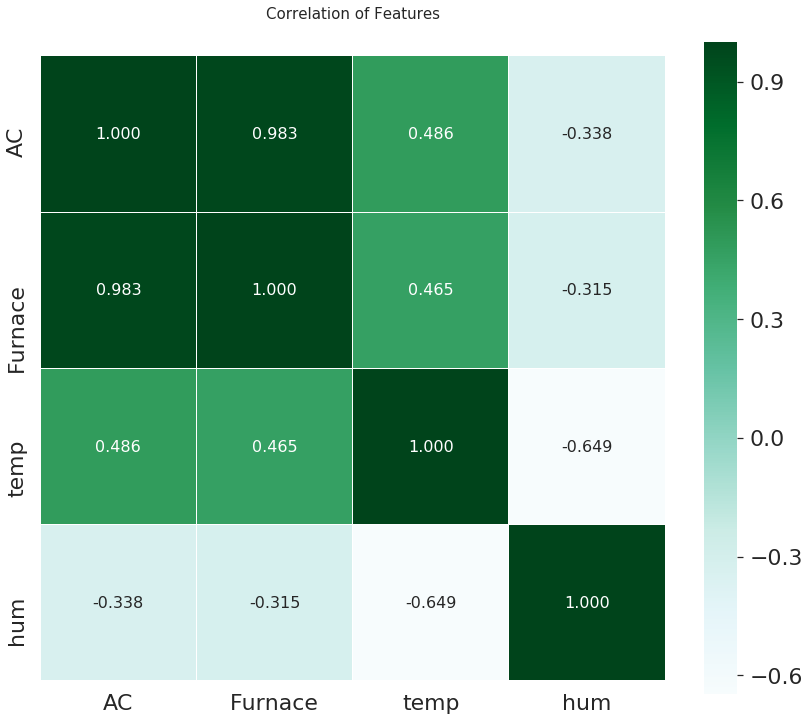

In [6]:
heatmap_data = df_train[['AC', 'Furnace', 'temp', 'hum']]
colormap = plt.cm.BuGn
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size':16}, fmt='.3f')

In [7]:
df_train['dayofweeks'].value_counts()

2    1296
1    1296
3    1272
0    1248
6    1224
5    1224
4    1224
Name: dayofweeks, dtype: int64

In [8]:
df_sun = df_train.loc[df_train['dayofweeks'] == 0]
df_mon = df_train.loc[df_train['dayofweeks'] == 1]
df_tue = df_train.loc[df_train['dayofweeks'] == 2]
df_wen = df_train.loc[df_train['dayofweeks'] == 3]
df_thu = df_train.loc[df_train['dayofweeks'] == 4]
df_fri = df_train.loc[df_train['dayofweeks'] == 5]
df_sat = df_train.loc[df_train['dayofweeks'] == 6]

In [9]:
ac_mean = df_tue['AC'].mean()
print(ac_mean)
df_np = df_tue.values.astype(np.float)
print(np.shape(df_np))

0.6337333281875
(1296, 5)


In [10]:
df_np_hour = []
for i in range((int(len(df_np)/24))):
    df_np_hour.append(df_np[i*24:i*24+24])

In [11]:
np.shape(df_np_hour)

(54, 24, 5)

In [12]:
delete_row = []

for i in range(len(df_np_hour)):
    cnt = 0
    for j in range(len(df_np_hour[i])):
        if(df_np_hour[i][j][0] < ac_mean):
            cnt += 1
    
    if(cnt == 24):
        delete_row.append(i)

In [13]:
cnt = 0
for i in range(len(delete_row)):
    df_np_hour = np.delete(df_np_hour, (i - cnt), axis=0)
    cnt += 1

In [14]:
df_all_np = []

for i in range(len(df_np_hour)):
    for j in range(len(df_np_hour[i])):
        temp = []
        for k in range(len(df_np_hour[i][j])):
            temp.append(df_np_hour[i][j][k])
        df_all_np.append(temp)

df_all_np = np.array(df_all_np)

In [15]:
scaler = MinMaxScaler()

AC = df_all_np[:, :1]
for i in range(len(AC)):
    if(AC[i][0] < ac_mean):
        AC[i][0] = 1
    else:
        AC[i][0] = 0

Furnace = df_all_np[:, 1:2]
norm_Furnace = scaler.fit_transform(Furnace)

temp = df_all_np[:, -2:-1]
norm_temp = scaler.fit_transform(temp)

hum = df_all_np[:, -1:]
norm_hum = scaler.fit_transform(hum)

x = np.concatenate((norm_temp, norm_hum), axis=1)
y = AC

In [17]:
train_size = int(len(x) * 0.7)
test_size = len(y) - train_size

trainX = np.array(x[0:train_size])
trainY = y[0:train_size]

testX = np.array(x[train_size:len(x)])
testY = y[train_size:len(y)]

X = tf.placeholder(tf.float32, shape=[None, 2])
Y = tf.placeholder(tf.float32, shape=[None, 1])

W = tf.Variable(tf.random_normal([2, 1]), name='weight')
b = tf.Variable(tf.random_normal([1]), name='bias')

H = tf.sigmoid(tf.matmul(X, W) + b)

cost = -tf.reduce_mean(Y * tf.log(H) + (1 - Y) * tf.log(1 - H))

train = tf.train.GradientDescentOptimizer(learning_rate = 0.001).minimize(cost)

predicted = tf.cast(H > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

c = ''

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for step in range(10001):
        cost_val, _ = sess.run([cost, train], feed_dict={X:trainX, Y:trainY})
        if step % 2000 == 0:
            print(step, cost_val)
            
#     h, c, a = sess.run([H, predicted, accuracy], feed_dict={X:x_data, Y:y_data})
    h, c, a = sess.run([H,predicted, accuracy], feed_dict={X:testX, Y:testY})
    print("\nHypothesis (sigmoid output)\n ", h, "\n\ntest_y_data", testY, "\n\nCorrect (predicted data)\n ", c, "\n\nAccuracy (정확도) : ", a)
#     print(h, c, a)

0 0.61225116
2000 0.56047785
4000 0.5456591
6000 0.5409721
8000 0.5393504
10000 0.53871924

Hypothesis (sigmoid output)
  [[0.7007019 ]
 [0.6675797 ]
 [0.63271344]
 [0.59640104]
 [0.57781243]
 [0.59640104]
 [0.6590161 ]
 [0.7242576 ]
 [0.753815  ]
 [0.73930746]
 [0.753815  ]
 [0.7608617 ]
 [0.80019045]
 [0.81217074]
 [0.82909334]
 [0.676034  ]
 [0.70868134]
 [0.74662983]
 [0.7608617 ]
 [0.7811614 ]
 [0.7939888 ]
 [0.80625093]
 [0.81217074]
 [0.823591  ]
 [0.81217074]
 [0.80019045]
 [0.7745356 ]
 [0.73930746]
 [0.6843748 ]
 [0.6590161 ]
 [0.6415783 ]
 [0.63271344]
 [0.6503475 ]
 [0.70868134]
 [0.80019045]
 [0.81217074]
 [0.8344585 ]
 [0.8344585 ]
 [0.84478253]
 [0.753815  ]
 [0.7745356 ]
 [0.80019045]
 [0.80625093]
 [0.81217074]
 [0.82909334]
 [0.82909334]
 [0.80019045]
 [0.71653414]
 [0.6147168 ]
 [0.5209188 ]
 [0.43502226]
 [0.37954858]
 [0.34415138]
 [0.33554876]
 [0.32705393]
 [0.32705393]
 [0.33554876]
 [0.34415138]
 [0.3886195 ]
 [0.46347728]
 [0.59640104]
 [0.63271344]
 [0.667579

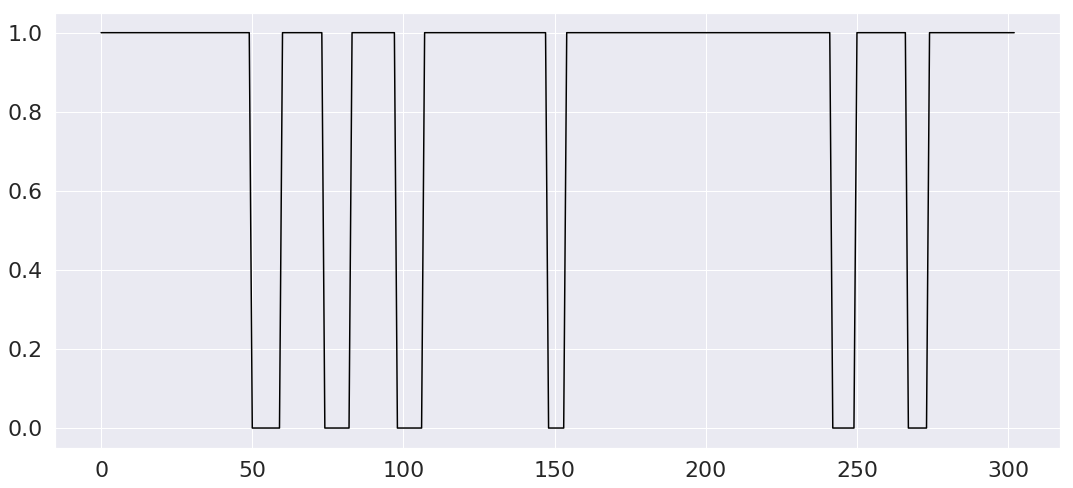

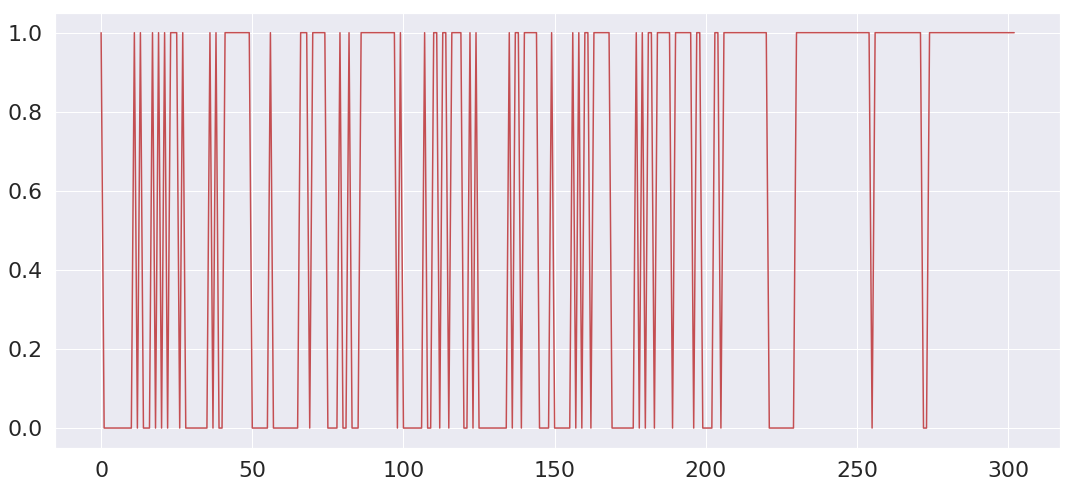

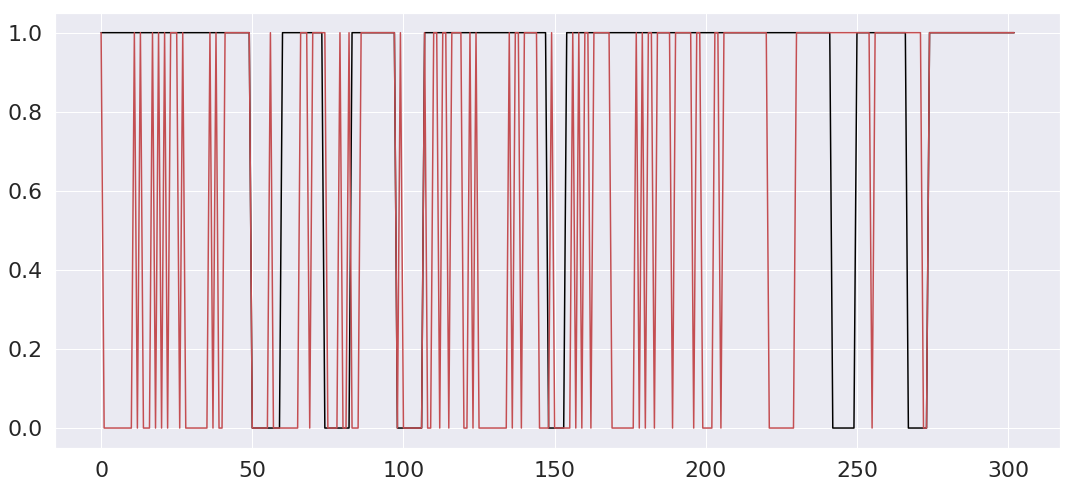

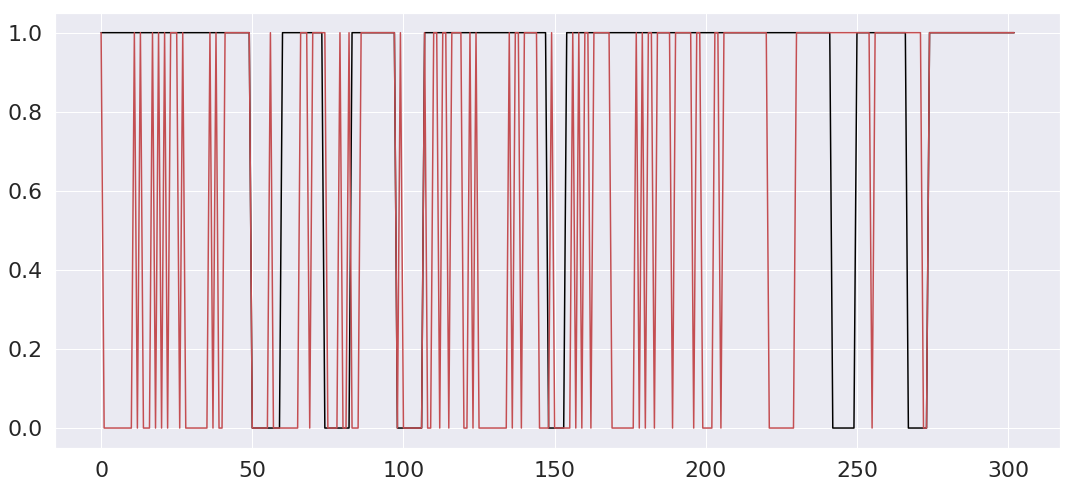

In [27]:
predict_Y = []
for i in range(len(c)):
    predict_Y.append(c[i][0])

test_Y = []
for i in range(len(testY)):
    test_Y.append(testY[i][0])
    
plt.figure(1, figsize=(18, 8))
plt.plot(predict_Y, 'black')

plt.figure(2, figsize=(18, 8))
plt.plot(test_Y, 'r')

plt.figure(3, figsize=(18, 8))
plt.plot(predict_Y, 'black')
plt.plot(test_Y, 'r')

plt.figure(4, figsize=(18, 8))
plt.plot(predict_Y, 'black')
plt.plot(test_Y, 'r')

In [ ]:
# plt.figure()
# plt.plot(y[:])
# plt.show()

In [ ]:
# input_data_column_cnt = 2
# output_data_column_cnt = 1

# seq_length = 1
# rnn_cell_hidden_dim = 30
# forget_bias = 1.0
# num_stacked_layers = 1
# keep_prob = 1.0

# epoch_num = 100
# learning_rate = 0.0001

# dataX = []
# dataY = []

# for i in range(0, len(y) - seq_length):
#     _x = x[i:i+seq_length]
#     _y = y[i+seq_length]
#     dataX.append(_x)
#     dataY.append(_y)

# train_size = int(len(dataY) * 0.7)
# test_size = len(dataY) - train_size

# trainX = np.array(dataX[0:train_size])
# trainY = dataY[0:train_size]

# testX = np.array(dataX[train_size:len(dataX)])
# testY = dataY[train_size:len(dataY)]

# X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt], name='X')
# Y = tf.placeholder(tf.float32, [None, 1], name='Y')

# targets = tf.placeholder(tf.float32, [None, 1], name='train_Y')
# predictions = tf.placeholder(tf.float32, [None, 1], name='predicted_Y')

# def lstm_cell():
#     cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.relu)
#     if keep_prob < 1.0:
#         cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
#     return cell

# stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
# multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

# hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)

# hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.nn.relu)
# loss = tf.reduce_sum(tf.square(hypothesis - Y))
# optimizer = tf.train.AdamOptimizer(learning_rate)

# train = optimizer.minimize(loss)
# rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

# train_error_summary = []
# test_error_summary = []
# test_predict = ''
# predict_array = []

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

# start_time = datetime.datetime.now()
# print('학습 시작')
# for epoch in range(epoch_num):
#     _, _loss = sess.run([train, loss], feed_dict={X:trainX, Y:trainY})
    
#     train_predict = sess.run(hypothesis, feed_dict = {X:trainX})
#     train_error = sess.run(rmse, feed_dict = {targets:trainY, predictions:train_predict})
#     train_error_summary.append(train_error)

#     test_predict = sess.run(hypothesis, feed_dict={X:testX})
#     test_error = sess.run(rmse, feed_dict={targets:testY, predictions:test_predict})
#     test_error_summary.append(test_error)
        
#     if((epoch+1) % 10 == 0) or (epoch == epoch_num - 1):
#         print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
# end_time = datetime.datetime.now()
# elapsed_time = end_time - start_time
# print('elapsed_time:', elapsed_time)
# print('elapsed_time per epoch:', elapsed_time/epoch_num)
# predict_array.append(test_predict)

In [ ]:
# plt.figure(1)
# plt.plot(train_error_summary, 'r')
# plt.plot(test_error_summary, 'b')
# plt.xlabel('Epoch(x700)')
# plt.ylabel('Root Mean Square Error')

# plt.figure(2)
# plt.plot(test_predict, 'b')
# plt.xlabel('Time Period')
# plt.ylabel('Electricity about Dryer (predict)')

# plt.figure(3)
# plt.plot(testY, 'r')
# plt.xlabel('Time Period')
# plt.ylabel('Electricity about Dryer (real)')
# plt.show()

In [ ]:
# testY = np.array(testY)
# scaler2 = MinMaxScaler(feature_range = (0, testY.max()))
# predict_array[0] = scaler2.fit_transform(predict_array[0])

# plt.figure()
# plt.plot(predict_array[0],'b')
# plt.plot(testY, 'g')
# plt.xlabel('Time Period')
# plt.ylabel('Electricity about Dryer (real)')
# plt.show()